In [1]:
from PIL import Image
import numpy as np
import numpy as np
import h5py
import matplotlib.pyplot as plt

import fastmri
from fastmri.data import transforms as T
from fastmri.data.subsample import RandomMaskFunc, EquiSpacedMaskFunc

In [2]:
# Apply the mask to the k-space data
def apply_custom_mask(kspace, mask):
    """Apply a custom mask to k-space data."""
    return kspace * mask

# Perform zero-filled reconstruction on masked k-space
def reconstruct_image(kspace):
    image = np.fft.ifftshift(np.fft.ifftn(np.fft.fftshift(kspace), axes=(1, 2)))
    #image = np.abs(image)
    final_image = np.sqrt(np.sum(image**2, axis=0))
    return np.abs(final_image)

def add_gaussian_noise(data, mean=0, std_dev=0.000000003, seed=None):
    # Generate Gaussian noise
    noise = np.random.normal(mean, std_dev, size=data.shape)
    noisy_data = data + noise 
    return noisy_data

In [3]:

# Load the k-space data
file_path = r'D:\Class Project\209\brain_multicoil_train_batch_1\file_brain_AXFLAIR_200_6002442.h5'
with h5py.File(file_path, 'r') as file:
    kspace = file['kspace'][0, :]  # Assuming this loads the first slice of multi-coil k-space data (e.g., shape (16, 640, 320))

# Create your 2D custom mask (this example assumes mask_2d has shape (640, 320))
np.random.seed(50)
mask_2d = np.random.choice([0, 1], size=(640, 320), p=[0.2, 0.8])  # Example random mask

# Broadcast the 2D mask across the coil dimension
mask_2d_broadcasted = np.broadcast_to(mask_2d, (16, 640, 320))

masked_kspace = apply_custom_mask(kspace, mask_2d_broadcasted)

# Reconstruct the image from the masked k-space data
noisy_img = reconstruct_image(masked_kspace)
#noisy_img = add_gaussian_noise(noisy_img, seed = 42)
ori_img = reconstruct_image(kspace)

# Visualize
plt.imshow(noisy_img, cmap='gray')  # Show the image from the first coil
plt.title('Noisy Image')
plt.axis('off')
plt.show()

plt.imshow(ori_img, cmap='gray')  # Show the image from the first coil
plt.title('Original Image')
plt.axis('off')
plt.show()



: 

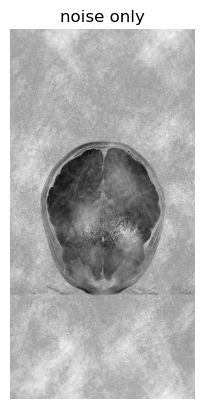

In [ ]:
plt.imshow(noisy_img - ori_img, cmap='gray')  
plt.title('noise only')
plt.axis('off')
plt.show()

In [ ]:

# Normalize the image data to the range [0, 255] for an 8-bit grayscale image
def normalize_image(image):
    image = image - np.min(image)  
    image = image / np.max(image)  
    image = (image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to 8-bit
    return image

# Normalize the image
normalized_noisy_image = normalize_image(noisy_img[5])  
normalized_image = normalize_image(ori_img[5])
# Convert the NumPy array to a PIL Image object
tiff_image_noisy = Image.fromarray(normalized_noisy_image)
tiff_image_ori = Image.fromarray(normalized_image)

# Save the image as a TIFF file
tiff_image_noisy.save(r'D:\Class Project\209\noisy_image4.tiff')  # Raw string to avoid issues
#tiff_image_ori.save(r'D:\Class Project\209\ori_image.tiff')



print("Image saved as TIFF.")


Image saved as TIFF.


TypeError: Invalid shape (640, 320, 2) for image data

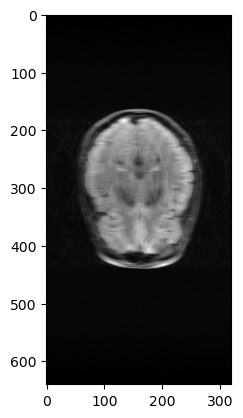

In [ ]:
#fastMRI methods

# Load the k-space data
file_path = r'D:\Class Project\209\brain_test_batch_0\file_brain_AXFLAIR_200_6002527.h5'
with h5py.File(file_path, 'r') as file:
    kspace = file['kspace'][0, :]  # Assuming this loads the first slice of multi-coil k-space data (e.g., shape (16, 640, 320))

kspace = T.to_tensor(kspace)
mask_func = RandomMaskFunc(center_fractions=[0.04], accelerations=[1])  # Create the mask function object
masked_kspace, mask, _ = T.apply_mask(kspace, mask_func)   # Apply the mask to k-space

sampled_image = fastmri.ifft2c(masked_kspace)           # Apply Inverse Fourier Transform to get the complex image
sampled_image_abs = fastmri.complex_abs(sampled_image)   # Compute absolute value to get a real image
sampled_image_rss = fastmri.rss(sampled_image_abs, dim=0)

plt.imshow(np.abs(sampled_image_rss.numpy()), cmap='gray')


# Reconstruct the image from the masked k-space data
noisy_img = fastmri.rss(masked_kspace, dim = 0)
#noisy_img = add_gaussian_noise(noisy_img, seed = 42)
ori_img = reconstruct_image(kspace)

# Visualize
plt.imshow(noisy_img, cmap='gray')  # Show the image from the first coil
plt.title('Noisy Image')
plt.axis('off')
plt.show()

plt.imshow(ori_img, cmap='gray')  # Show the image from the first coil
plt.title('Original Image')
plt.axis('off')
plt.show()

